<a href="https://colab.research.google.com/github/raphaelp-silva/Curso-em-video/blob/main/Update_Graphs_obesity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install faiss-cpu
!pip install torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00


In [2]:
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch
import faiss
import networkx as nx


In [3]:
import kagglehub

# Fazendo o download da ultima versão via api
path = kagglehub.dataset_download("adeniranstephen/obesity-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 32.7k/32.7k [00:00<00:00, 33.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/adeniranstephen/obesity-prediction-dataset/versions/1


In [4]:
os.listdir(path) #listando os arquivos do diretorio

db = pd.read_csv(os.path.join(path, "ObesityDataSet_raw_and_data_sinthetic.csv"))

In [5]:
db.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
# Convertendo colunas (yes/no) para valores binários:

colunas_binarias = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

db.loc[:, colunas_binarias] = db[colunas_binarias].apply(lambda x: x.map({'yes': 1, 'no': 0})).astype(int)

# Convertendo coluna 'Gender' para valores binários:

db.loc[:, 'Gender'] = db['Gender'].map({'Female': 0, 'Male': 1})

In [7]:
# Convertendo valores das colunas de caracteres para valores numéricos:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Lista das colunas categóricas que vamos transformar:
categorical_columns = ['CAEC', 'CALC', 'MTRANS', 'NObeyesdad']

# Criando o OneHotEncoder e aplicando em todas as colunas de uma vez:
onehotencoder = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(), categorical_columns)], remainder='passthrough')

# Transformando os valores:
encoded_data = onehotencoder.fit_transform(db)

# retornando os nomes das colunas geradas com o onehotencoder:
transformed_feature_names = onehotencoder.get_feature_names_out()

# criando um novo DataFrame com os valores:
encoded_df = pd.DataFrame(encoded_data, columns=transformed_feature_names).astype('int')

db_encoded = pd.concat([db.drop(columns=categorical_columns), encoded_df], axis=1)

In [8]:
# Dropando as colunas 'remainder__' que estão duplicadas no db_encoded:

db_encoded = db_encoded.drop(columns=[col for col in db_encoded.columns if 'remainder__' in col])

## Normalizando os dados utilizando StandardScaler:

In [9]:
from sklearn.preprocessing import StandardScaler

lista_colunas_a_normalizar = ['Age', 'Height', 'Weight', 'CH2O', 'FAF', 'TUE']

# Normalizando os dados:
scaler = StandardScaler()
db_encoded[lista_colunas_a_normalizar] = scaler.fit_transform(db_encoded[lista_colunas_a_normalizar])

In [10]:
db_encoded.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,OneHot__MTRANS_Motorbike,OneHot__MTRANS_Public_Transportation,OneHot__MTRANS_Walking,OneHot__NObeyesdad_Insufficient_Weight,OneHot__NObeyesdad_Normal_Weight,OneHot__NObeyesdad_Obesity_Type_I,OneHot__NObeyesdad_Obesity_Type_II,OneHot__NObeyesdad_Obesity_Type_III,OneHot__NObeyesdad_Overweight_Level_I,OneHot__NObeyesdad_Overweight_Level_II
0,0,-0.521741,-0.874380,-0.862558,1,0,2.0,3.0,0,-0.013141,...,0,1,0,0,1,0,0,0,0,0
1,0,-0.521741,-1.945660,-1.168077,1,0,3.0,3.0,1,1.618701,...,0,1,0,0,1,0,0,0,0,0
2,1,-0.207057,1.053924,-0.366089,1,0,2.0,3.0,0,-0.013141,...,0,1,0,0,1,0,0,0,0,0
3,1,0.422312,1.053924,0.015809,0,0,3.0,3.0,0,-0.013141,...,0,0,1,0,0,0,0,0,1,0
4,1,-0.364399,0.839668,0.122741,0,0,2.0,1.0,0,-0.013141,...,0,1,0,0,0,0,0,0,0,1


In [11]:
db_encoded.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'OneHot__CAEC_Always', 'OneHot__CAEC_Frequently',
       'OneHot__CAEC_Sometimes', 'OneHot__CAEC_no', 'OneHot__CALC_Always',
       'OneHot__CALC_Frequently', 'OneHot__CALC_Sometimes', 'OneHot__CALC_no',
       'OneHot__MTRANS_Automobile', 'OneHot__MTRANS_Bike',
       'OneHot__MTRANS_Motorbike', 'OneHot__MTRANS_Public_Transportation',
       'OneHot__MTRANS_Walking', 'OneHot__NObeyesdad_Insufficient_Weight',
       'OneHot__NObeyesdad_Normal_Weight', 'OneHot__NObeyesdad_Obesity_Type_I',
       'OneHot__NObeyesdad_Obesity_Type_II',
       'OneHot__NObeyesdad_Obesity_Type_III',
       'OneHot__NObeyesdad_Overweight_Level_I',
       'OneHot__NObeyesdad_Overweight_Level_II'],
      dtype='object')

In [12]:
target_columns = ['OneHot__NObeyesdad_Insufficient_Weight',
                 'OneHot__NObeyesdad_Normal_Weight',
                 'OneHot__NObeyesdad_Obesity_Type_I',
                 'OneHot__NObeyesdad_Obesity_Type_II',
                 'OneHot__NObeyesdad_Obesity_Type_III',
                 'OneHot__NObeyesdad_Overweight_Level_I',
                 'OneHot__NObeyesdad_Overweight_Level_II']

In [13]:
X = db_encoded.drop(columns=target_columns)
y = db_encoded[target_columns]

In [14]:
# dividindo em treino (70%):
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) #stratify serve para manter a mesma proporcao das classes da variavel alvo (y) tanto no conjunto de treino quanto no de teste.

# dividindo o restante em validação(15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# verificando o tamanho das divisões:
print(f"Tamanho do conjunto treino: {len(X_train)}")
print(f"Tamanho do conjunto validação: {len(X_val)}")
print(f"Tamanho do conjunto teste: {len(X_test)}")

Tamanho do conjunto treino: 1477
Tamanho do conjunto validação: 317
Tamanho do conjunto teste: 317


##  Agrupando o número de amostra por classe no conjunto de treinamento:

In [15]:
# Convertendo one-hot para rótulos inteiros novamente para contar:
y_train_labels = np.argmax(y_train, axis=1)

# Contando quantas amostras de cada classe:
classe_counts = pd.Series(y_train_labels).value_counts().sort_index()

print("Distribuição por classe no y_train:")
print(classe_counts)

Distribuição por classe no y_train:
0    190
1    201
2    245
3    208
4    227
5    203
6    203
Name: count, dtype: int64


In [16]:
# convertendo as colunas para tipo float:
object_columns = db_encoded.select_dtypes(include=['object']).columns # selecionando as colunas do tipo objeto.

for col in object_columns:
    db_encoded[col] = pd.to_numeric(db_encoded[col], errors='coerce')

In [17]:
db_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 33 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Gender                                  2111 non-null   int64  
 1   Age                                     2111 non-null   float64
 2   Height                                  2111 non-null   float64
 3   Weight                                  2111 non-null   float64
 4   family_history_with_overweight          2111 non-null   int64  
 5   FAVC                                    2111 non-null   int64  
 6   FCVC                                    2111 non-null   float64
 7   NCP                                     2111 non-null   float64
 8   SMOKE                                   2111 non-null   int64  
 9   CH2O                                    2111 non-null   float64
 10  SCC                                     2111 non-null   int6

In [18]:
print(X_train.shape)

(1477, 26)


In [19]:
# Tentando utilizar o FAISS para criação das conexões no grafo, caso contrário utiliza o sklearn:
try:
  import faiss
  use_faiss = True
except:
  from sklearn.neighbors import NearestNeighbors
  use_faiss = False

In [20]:
# Criando a função que processa os dados de entrada dos grafos.

def preprocess_features(X, y):
    """
    Preprocessa os dados de entrada:
    - Preenche valores ausentes com 0
    - Converte X para float32 e y para int

    Retorna:
        X (DataFrame), y (Series)
    """
    X = X.fillna(0).astype(np.float32)
    y = y.fillna(0).astype(int)
    return X, y

In [21]:
# Criando a função que cria o grafo baseado em distância Euclidiana.

def build_knn_graph(X_np, k):
    """
    Cria um grafo k-NN baseado em distância Euclidiana.

    Retorna:
        edge_index (torch.LongTensor): Formato [2, num_edges]
    """
    num_nodes = X_np.shape[0]

    if use_faiss:
        index = faiss.IndexFlatL2(X_np.shape[1])
        index.add(X_np)
        _, neighbors = index.search(X_np, k + 1)
    else:
        nn = NearestNeighbors(n_neighbors=k + 1).fit(X_np)
        neighbors = nn.kneighbors(X_np, return_distance=False)

    # Pré-alocação de arestas (bidirecional)
    edges = np.zeros((2, num_nodes * k * 2), dtype=np.int64)
    idx = 0
    for i in range(num_nodes):
        for j in range(1, k + 1):  # Ignora o próprio nó
            neighbor = neighbors[i, j]
            edges[0, idx] = i
            edges[1, idx] = neighbor
            idx += 1
            edges[0, idx] = neighbor
            edges[1, idx] = i
            idx += 1

    return torch.from_numpy(edges)

In [34]:
# Criando a função de coversão de dataframe para PyG.

def df_to_pyg_with_edges(X, y, k=5):
    """
    Converte um DataFrame (X) e seus rótulos (y) em um objeto Data do PyTorch Geometric.
    Cria arestas entre os k vizinhos mais próximos usando FAISS ou sklearn.

    Parâmetros:
        X (pd.DataFrame): Features dos nós.
        y (pd.Series): Rótulos dos nós.
        k (int): Número de vizinhos para conectar cada nó.

    Retorna:
        Data: Objeto do PyG com x, edge_index e y.
    """
    X, y = preprocess_features(X, y)
    X_np = X.values.astype(np.float32)

    edge_index = build_knn_graph(X_np, k)
    x_tensor = torch.tensor(X.values, dtype=torch.float)
    y_tensor = torch.tensor(y.values, dtype=torch.long).argmax(dim=1)

    print(y_tensor.shape) #imprimindo o formato para validar se está no formato correto.

    return Data(x=x_tensor, edge_index=edge_index, y=y_tensor)

In [35]:
# Criando os grafos com conexões baseadas em similaridade

graph_train = df_to_pyg_with_edges(X_train, y_train, k=5)
graph_val = df_to_pyg_with_edges(X_val, y_val, k=5)
graph_test = df_to_pyg_with_edges(X_test, y_test, k=5)

# Exibir informações sobre os grafos

print(graph_train)
print(graph_val)
print(graph_test)

torch.Size([1477])
torch.Size([317])
torch.Size([317])
Data(x=[1477, 26], edge_index=[2, 14770], y=[1477])
Data(x=[317, 26], edge_index=[2, 3170], y=[317])
Data(x=[317, 26], edge_index=[2, 3170], y=[317])


<ipython-input-20-5d02498e51ca>:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0).astype(np.float32)
<ipython-input-20-5d02498e51ca>:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0).astype(np.float32)
<ipython-input-20-5d02498e51ca>:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0).astype(n

In [44]:
# Criando a função para plotar o grafo:

import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(graph, df):
    """Plota o grafo usando NetworkX e Matplotlib."""

    # Criar o grafo no NetworkX
    G = nx.Graph()
    edge_list = graph.edge_index.numpy().T  # Converter as arestas para NumPy
    G.add_edges_from(edge_list)  # Adicionar arestas ao NetworkX

    # Garantir que os índices do DataFrame estejam alinhados corretamente com os nós
    df = df.reset_index(drop=True)  # Resetar os índices para garantir alinhamento correto

    # Definir cores dos nós com base na obesidade (ou outro critério)
    color_map = [
        "blue" if (df.loc[node, "OneHot__NObeyesdad_Normal_Weight"] == 1 or
                   df.loc[node, "OneHot__NObeyesdad_Insufficient_Weight"] == 1) else "red"
        for node in G.nodes()
    ]

    # Plotar o grafo
    plt.figure(figsize=(10, 6))
    nx.draw(G, node_color=color_map, node_size=5, edge_color="gray", alpha=0.7, width=0.2)
    plt.title("Grafo de Indivíduos Conectados por Similaridade")
    plt.show()


In [45]:
type(graph_train.edge_index)


torch.Tensor

## Grafo de treino

<ipython-input-20-5d02498e51ca>:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0).astype(np.float32)


torch.Size([1477])


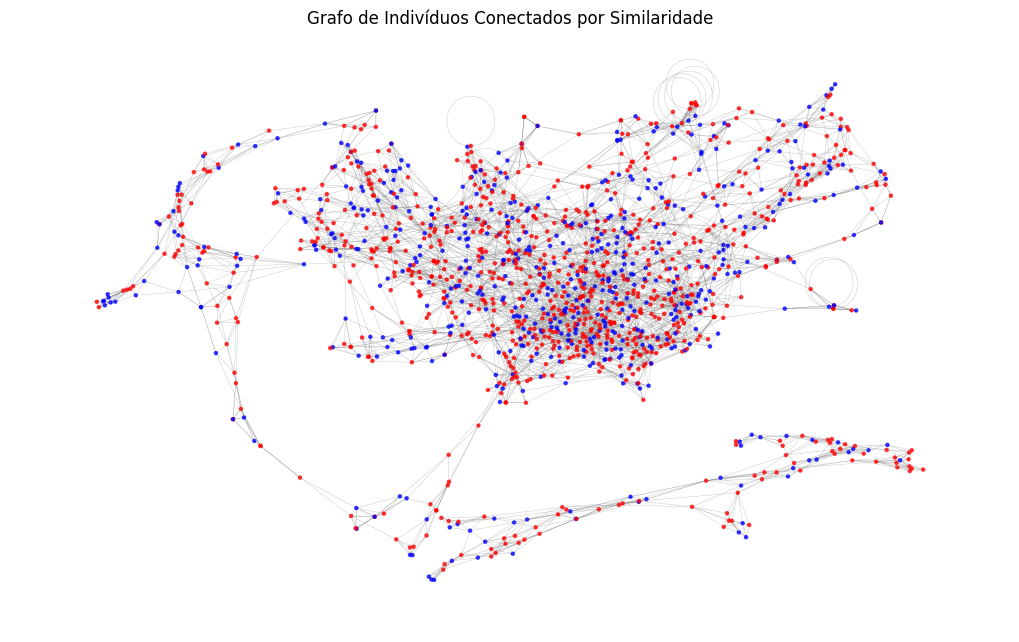

In [46]:
# Criar e visualizar o grafo de treino

graph_train = df_to_pyg_with_edges(X_train, y_train, k=5)
plot_graph(graph_train, db_encoded)

## Grafo de teste

<ipython-input-20-5d02498e51ca>:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0).astype(np.float32)


torch.Size([317])


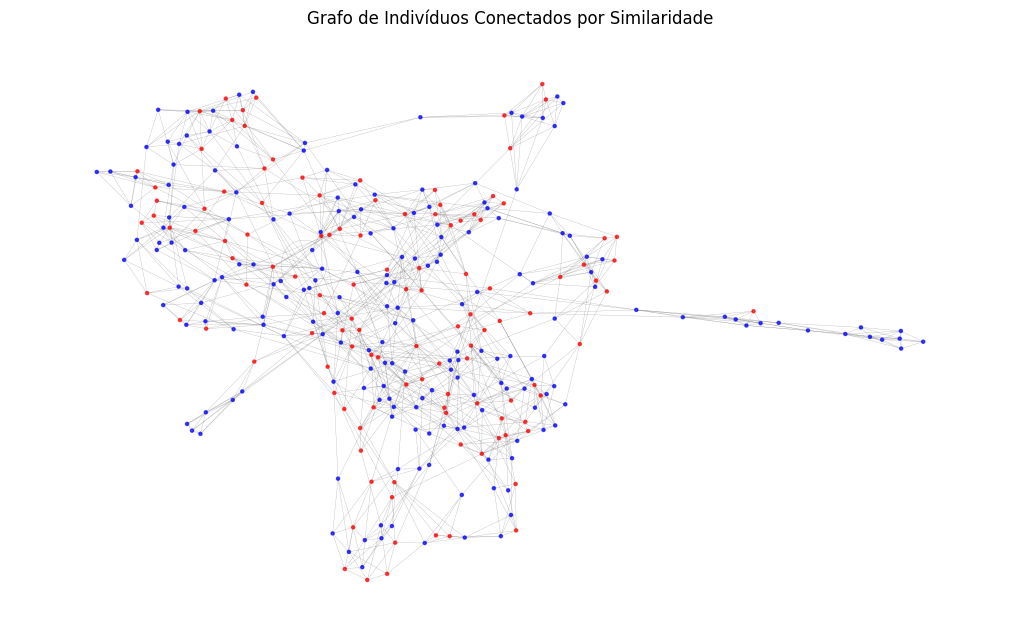

In [47]:
# Criar e visualizar o grafo de teste

graph_test = df_to_pyg_with_edges(X_test, y_test, k=5)
plot_graph(graph_test, db_encoded)

## Grafo de validação

<ipython-input-20-5d02498e51ca>:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0).astype(np.float32)


torch.Size([317])


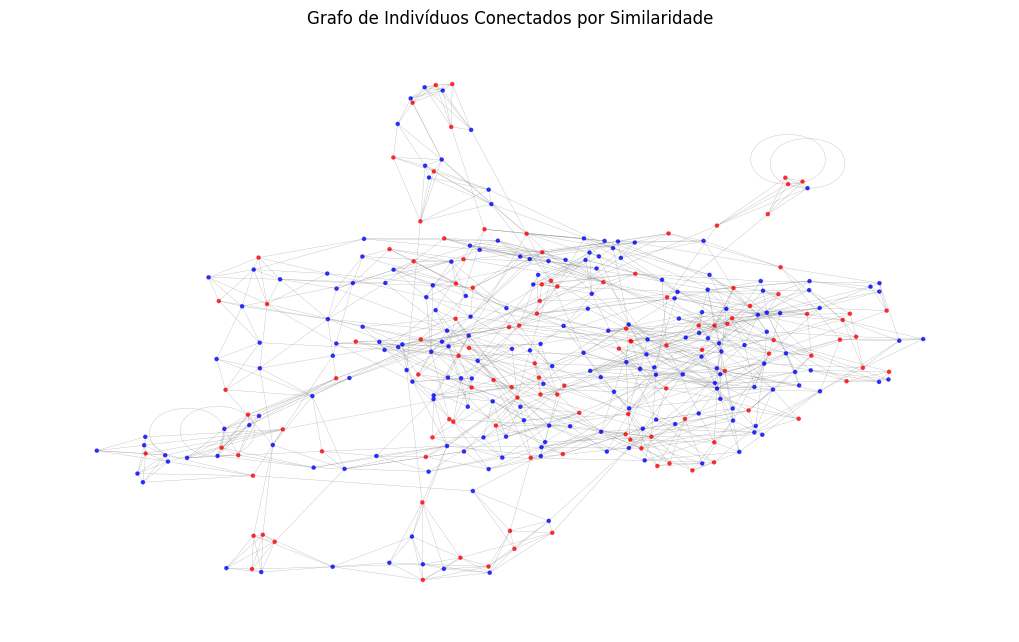

In [48]:
# Criar e visualizar o grafo de validacao

graph_train = df_to_pyg_with_edges(X_val, y_val, k=5)
plot_graph(graph_val, db_encoded)

In [49]:
from google.colab import files

# salvando o grafo de treinamento:
torch.save(graph_train, 'graph_train.pt')

# salvando o grafo de teste:
torch.save(graph_test, 'graph_test.pt')

# salvando o grafo de validação:
torch.save(graph_val, 'graph_val.pt')